### Tracking with btrack

In [1]:
### Imports
# Standard library imports
import json
import os
import shutil
import logging
import sys

# Third-party imports
# Data handling
import numpy as np
import pandas as pd

# Image I/O and processing
import tifffile as tiff
from nd2reader import ND2Reader
from skimage.morphology import remove_small_objects

# Deep learning and segmentation
from csbdeep.utils import Path, normalize
from stardist import (
    fill_label_holes,
    random_label_cmap,
    calculate_extents,
    gputools_available,
)
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from tensorflow.keras.utils import Sequence

# Tracking
import btrack
from btrack.constants import BayesianUpdates

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Utilities
from tqdm import tqdm

from datetime import datetime

2025-04-09 16:03:44.281966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744207424.296602  809765 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744207424.301337  809765 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 16:03:44.318710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Variables
## Directory Paths
# Input
IMG_DIR = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs'
APO_DIR = '/mnt/imaging.data/PertzLab/apoDetection/ApoptosisAnnotation'
EXPERIMENT_INFO = '/mnt/imaging.data/PertzLab/apoDetection/List of the experiments.csv'
MASK_DIR = '../data/dataset1/apo_masks'    # Stardist label predictions

# Output
TRACKED_MASK_DIR = '../data/tracked_masks'
CSV_DIR = '../data/apo_match_csv'    # File with manual and stardist centroids
DF_DIR = '../data/dataset1/summary_dfs'
TRACK_DF_DIR = '../data/track_dfs'
CROPS_DIR = '../data/apo_crops_test'    # Directory with .tif files for QC
WINDOWS_DIR = '/home/nbahou/myimaging/apoDet/data/windows_test'    # Directory with crops for scDINO
RANDOM_DIR = os.path.join(WINDOWS_DIR, 'random')
CLASS_DCT_PATH = './extras/class_dicts'


## Processing Configuration
COMPARE_2D_VERS = True
SAVE_MASKS = True
LOAD_MASKS = True
USE_GPU = True
MIN_NUC_SIZE = 200

## Tracking Parameters
BT_CONFIG_FILE = '/home/nbahou/myimaging/apoDet/scripts/extras/cell_config_20x.json'
# BT_CONFIG_FILE = "extras/cell_config.json"  # Path to btrack config file
# EPS_TRACK = 70         # Tracking radius [px]
EPS_TRACK = 30         # Tracking radius [px]
TRK_MIN_LEN = 25       # Minimum track length [frames]

#
MAX_TRACKING_DURATION = 20    # In minutes
FRAME_INTERVAL = 5    # minutes between images we want

WINDOW_SIZE = 61


## Logger Set Up
#logging.shutdown()    # For jupyter notebooks
logger = logging.getLogger(__name__)
#if logger.hasHandlers():
#    logger.handlers.clear()
# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define log directory and ensure it exists
log_dir = "./logs"  # Folder for logs
os.makedirs(log_dir, exist_ok=True)  # Create directory if it doesn't exist

log_filename = f"tracking_Btrack_{timestamp}.log"
log_path = os.path.join(log_dir, log_filename)

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_path),
        logging.StreamHandler(sys.stdout)  # Outputs to console too
    ],
    force = True
)

# Create a logger instance
logger = logging.getLogger(__name__)

# Only forward Warnings/Errors/Critical from btrack
logging.getLogger('btrack').setLevel(logging.WARNING)


In [3]:
def load_image_stack(path):
    """
    Load an image stack from a file based on its extension.
    
    Uses tifffile for TIFF files and ND2Reader for ND2 files.
    """
    if path.endswith(('.tif', '.tiff')):
        # Load TIFF file using tifffile
        return tiff.imread(path)
    elif path.endswith('.nd2'):
        # Load ND2 file using ND2Reader and convert it to a numpy array
        with ND2Reader(path) as nd2:
            return np.array(nd2)
    else:
        raise ValueError(f"Unsupported file format for file: {path}")

def get_image_paths(directory):
    """
    Returns a list of absolute paths of all TIFF and ND2 files in a directory.
    """
    valid_extensions = ('.tif', '.tiff', '.nd2')
    paths = [
        os.path.abspath(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(valid_extensions)
    ]
    return sorted(paths)

def crop_window(img, center_x, center_y, window_size):
    # Check if number is even, add one if so
    if window_size%2 == 0:
        window_size += 1
        logger.warning(f'\t\tWindow size even, adding 1. New window size: {window_size}')
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size + 1, img.shape[1])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size + 1, img.shape[0])
    window = img[y_from:y_to, x_from:x_to]

    return window



def run_tracking(gt_filtered, fovX, fovY, bt_config_file, track_radius):
    logging.info("\tStarting tracking")
    gt_filtered = gt_filtered#[::5]
    btObj = btrack.utils.segmentation_to_objects(gt_filtered, properties=("area",), assign_class_ID=True)
    
    with btrack.BayesianTracker() as tracker:
        tracker.configure(bt_config_file)
        tracker.update_method = BayesianUpdates.APPROXIMATE
        tracker.max_search_radius = track_radius
        tracker.append(btObj)
        tracker.volume = ((0, fovX), (0, fovY))
        tracker.track(step_size=100)
        tracker.optimize()
        btTracks = tracker.tracks
    
    dfBTracks = pd.concat(pd.DataFrame(t.to_dict(["ID", "t", "x", "y"])) for t in btTracks)
    dfBTracks.rename(columns={"ID": "track_id", "t": "t", "x": "x", "y": "y", "class_id": "obj_id"}, inplace=True)
    dfBTracks["obj_id"] = dfBTracks["obj_id"].astype("Int32")
    logging.info("\t\tTracking Done.")
    return dfBTracks


def convert_obj_to_track_ids(gt_filtered, merged_df):
    """
    Converts object IDs to track IDs in Stardist masks using tracking data.

    Parameters:
        gt_filtered (np.ndarray): The 3D array (time, height, width) of segmentation masks.
        merged_df (pd.DataFrame): DataFrame containing tracking information with 'obj_id', 'track_id', and 't'.

    Returns:
        np.ndarray: New 3D mask where obj_ids are replaced with track_ids.
    """
    
    tracked_masks = np.zeros_like(gt_filtered)

    for t, mask_frame in enumerate(gt_filtered):
        current_df = merged_df[merged_df['t'] == t]

        # Create a mapping {obj_id: track_id} for this timepoint
        obj_to_track = current_df.set_index('obj_id')['track_id'].to_dict()

        # Replace obj_id in the mask with the corresponding track_id
        for obj_id, track_id in obj_to_track.items():
            if pd.isna(track_id):
                continue
            
            tracked_masks[t][mask_frame == obj_id] = track_id

    return tracked_masks


def remove_outlier_frames(label_stack, thr_multiplier = 20):
    bin_imgs = np.copy(label_stack)
    bin_imgs[label_stack != 0] = 1

    min_differences = []
    for i, img in enumerate(bin_imgs):
        if i == 0:
            diff = np.abs(img - bin_imgs[i + 1])
            sad = np.sum(diff)
            min_differences.append(sad)
        elif i == len(bin_imgs)-1:
            diff = np.abs(bin_imgs[i - 1] - img)
            sad = np.sum(diff)
            min_differences.append(sad)
        else:
            diff1 = np.abs(img - bin_imgs[i + 1])
            diff2 = np.abs(img - bin_imgs[i - 1])
            sad1 = np.sum(diff1)
            sad2 = np.sum(diff2)
    
            min_sad = min(sad1, sad2)
            min_differences.append(min_sad)
    # Convert to numpy arrays
    min_differences = np.array(min_differences)

    median = np.median(min_differences)
    mad = np.median(np.abs(min_differences - median))
    threshold = median + thr_multiplier * mad

    # Find outlier indices
    outlier_indices = np.where(min_differences > threshold)[0]
    
    # Replace outlier frames with zero
    cleaned_stack = np.copy(label_stack)
    for idx in outlier_indices:
        cleaned_stack[idx] = np.zeros_like(label_stack[idx])
    
    return cleaned_stack, outlier_indices

In [4]:
# Load image paths in specified directory
logger.info("Starting Image Processing")
image_paths = get_image_paths(os.path.join(IMG_DIR))
filenames = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]    ### TODO remove :2 here, was only for testing
logger.info(f"Detected {len(filenames)} files in specified directories.")
filenames = filenames[64:67]
# filenames = filenames[77:79]
print(filenames)

2025-04-09 16:03:48,232 - __main__ - INFO - Starting Image Processing
2025-04-09 16:03:48,235 - __main__ - INFO - Detected 219 files in specified directories.
['Exp07_Site01', 'Exp07_Site02', 'Exp07_Site03']


In [ ]:


# Create directories for saving if they do not exist
output_dirs = [MASK_DIR, DF_DIR, TRACK_DF_DIR, TRACKED_MASK_DIR]
for path in output_dirs:
    os.makedirs(path, exist_ok=True)

# Loop over all files in target directory (predict labels, track and crop windows for each)
logger.info("Starting to process files.")
for path, filename in zip(image_paths, filenames):
    # Define and load labels
    mask_path = os.path.join(MASK_DIR, f'{filename}.npz')
    with np.load(mask_path) as data:
        gt_filtered = data['gt']  # Access the saved array

    gt_filtered, indices = remove_outlier_frames(gt_filtered)
    logger.info(f'{len(indices)} outlier frames replaced by frame with zeroes.')
    
    df_path = os.path.join(DF_DIR, f'{filename}_pd_df.csv')
    strdst_df =  pd.read_csv(df_path, header=0)

    # Run tracking with Btrack
    _, fovY, fovX = gt_filtered.shape
    dfBTracks = run_tracking(gt_filtered, fovX, fovY, BT_CONFIG_FILE, EPS_TRACK)
    
    logger.info("\tMerging information from Btrack and stardist.")
    merged_df = strdst_df.merge(dfBTracks.drop(columns=["x", "y", "area"]), on=["obj_id", "t"], how="left")
    # Enable next line if you only want tracks which are longer than TRK_MIN_LEN
    # merged_df = merged_df[merged_df.groupby("track_id")["track_id"].transform('size') >= TRK_MIN_LEN].copy()
    logger.info("\t\tComplete.")

    # Save merged DataFrame to a CSV file
    merge_df_path = os.path.join(TRACK_DF_DIR, f"{filename}.csv")
    #merged_df.to_csv(merge_df_path, index=False)
    logger.info(f"\tSaved merged dfs at: {merge_df_path}")

    ### Create a mask with btrack track_ids instead of stardists obj_ids
    logger.info("\tConverting Obj_IDs to Track_IDs in stardist masks.")
    tracked_masks = convert_obj_to_track_ids(gt_filtered, merged_df)
    
    # Save masks
    mask_path = os.path.join(TRACKED_MASK_DIR, f'{filename}.npz')
    #np.savez_compressed(mask_path, gt=tracked_masks)
    logger.info(f"\t\tMask saved at: {mask_path}")
    

2025-04-09 11:20:35,029 - __main__ - INFO - Starting to process files.
2025-04-09 11:20:47,715 - __main__ - INFO - 0 outlier frames replaced by frame with zeroes.
2025-04-09 11:20:49,191 - root - INFO - 	Starting tracking


100%|███████████████████████████████████████████████████████████████████████████████| 1930/1930 [06:08<00:00,  5.23it/s]


In [5]:
# Create directories for saving if they do not exist
output_dirs = [MASK_DIR, DF_DIR, TRACK_DF_DIR, TRACKED_MASK_DIR]
for path in output_dirs:
    os.makedirs(path, exist_ok=True)

# Loop over all files in target directory (predict labels, track and crop windows for each)
logger.info("Starting to process files.")
for path, filename in zip(image_paths, filenames):
    # Define and load labels
    mask_path = os.path.join(MASK_DIR, f'{filename}.npz')
    with np.load(mask_path) as data:
        gt_filtered = data['gt']  # Access the saved array

    gt_filtered, indices = remove_outlier_frames(gt_filtered)
    logger.info(f'{len(indices)} outlier frames replaced by frame with zeroes.')
    
    df_path = os.path.join(DF_DIR, f'{filename}_pd_df.csv')
    strdst_df =  pd.read_csv(df_path, header=0)

    # Run tracking with Btrack
    _, fovY, fovX = gt_filtered.shape
    logging.info("\tStarting tracking")
    gt_filtered = gt_filtered#[::5]
    btObj = btrack.utils.segmentation_to_objects(gt_filtered, properties=("area",), assign_class_ID=True)
    
    with btrack.BayesianTracker() as tracker:
        tracker.configure(BT_CONFIG_FILE)
        tracker.update_method = BayesianUpdates.APPROXIMATE
        tracker.max_search_radius = EPS_TRACK
        tracker.append(btObj)
        tracker.volume = ((0, fovX), (0, fovY))
        tracker.track(step_size=100)
        tracker.optimize()
        btTracks = tracker.tracks
    
    dfBTracks = pd.concat(pd.DataFrame(t.to_dict(["ID", "t", "x", "y"])) for t in btTracks)
    dfBTracks.rename(columns={"ID": "track_id", "t": "t", "x": "x", "y": "y", "class_id": "obj_id"}, inplace=True)
    dfBTracks["obj_id"] = dfBTracks["obj_id"].astype("Int32")
    logging.info("\t\tTracking Done.")
    
    logger.info("\tMerging information from Btrack and stardist.")
    merged_df = strdst_df.merge(dfBTracks.drop(columns=["x", "y", "area"]), on=["obj_id", "t"], how="left")
    # Enable next line if you only want tracks which are longer than TRK_MIN_LEN
    # merged_df = merged_df[merged_df.groupby("track_id")["track_id"].transform('size') >= TRK_MIN_LEN].copy()
    logger.info("\t\tComplete.")

    # Save merged DataFrame to a CSV file
    merge_df_path = os.path.join(TRACK_DF_DIR, f"{filename}.csv")
    #merged_df.to_csv(merge_df_path, index=False)
    logger.info(f"\tSaved merged dfs at: {merge_df_path}")

    ### Create a mask with btrack track_ids instead of stardists obj_ids
    logger.info("\tConverting Obj_IDs to Track_IDs in stardist masks.")
    tracked_masks = convert_obj_to_track_ids(gt_filtered, merged_df)
    
    # Save masks
    mask_path = os.path.join(TRACKED_MASK_DIR, f'{filename}.npz')
    #np.savez_compressed(mask_path, gt=tracked_masks)
    logger.info(f"\t\tMask saved at: {mask_path}")

2025-04-09 16:03:54,132 - __main__ - INFO - Starting to process files.
2025-04-09 16:04:04,974 - __main__ - INFO - 58 outlier frames replaced by frame with zeroes.
2025-04-09 16:04:05,429 - root - INFO - 	Starting tracking


100%|███████████████████████████████████████████████████████████████████████████████| 1930/1930 [05:54<00:00,  5.45it/s]


GLPK Integer Optimizer 5.0
116796 rows, 92573 columns, 126751 non-zeros
92573 integer variables, all of which are binary
Preprocessing...
58398 rows, 92573 columns, 126751 non-zeros
92573 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 58398
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
58398 rows, 92573 columns, 126751 non-zeros
*     0: obj =   3.482025910e+05 inf =   0.000e+00 (23587)
*  4201: obj =   2.927424428e+05 inf =   0.000e+00 (19380)
Perturbing LP to avoid stalling [4915]...
*  6969: obj =   2.727185697e+05 inf =   0.000e+00 (16900)
*  9623: obj =   2.547782985e+05 inf =   0.000e+00 (14565)
* 12314: obj =   2.358469136e+05 inf =   0.000e+00 (12184)
* 15025: obj =   2.162473622e+05 inf =   0.000e+00 (9748)
* 17707: obj =   1.970598468e+05 inf =   0.000e+00 (7359)
* 20461: obj =   1.791565691e+05 inf =   

KeyboardInterrupt: 

In [6]:
print(merged_df[merged_df['track_id'].isna()])

         obj_id     t     x     y  track_id
67005         1    40   560   600       NaN
67006         4    40    66   758       NaN
67007         5    40   624    62       NaN
67008         6    40   326   310       NaN
67009         7    40   974   850       NaN
...         ...   ...   ...   ...       ...
3401001    2301  1900  1018   808       NaN
3401002    2308  1900   574  1018       NaN
3401003    2318  1900  1018    48       NaN
3401004    2334  1900     4   190       NaN
3401005    2357  1900   220   926       NaN

[103469 rows x 5 columns]


## Refined config, optimization possible now

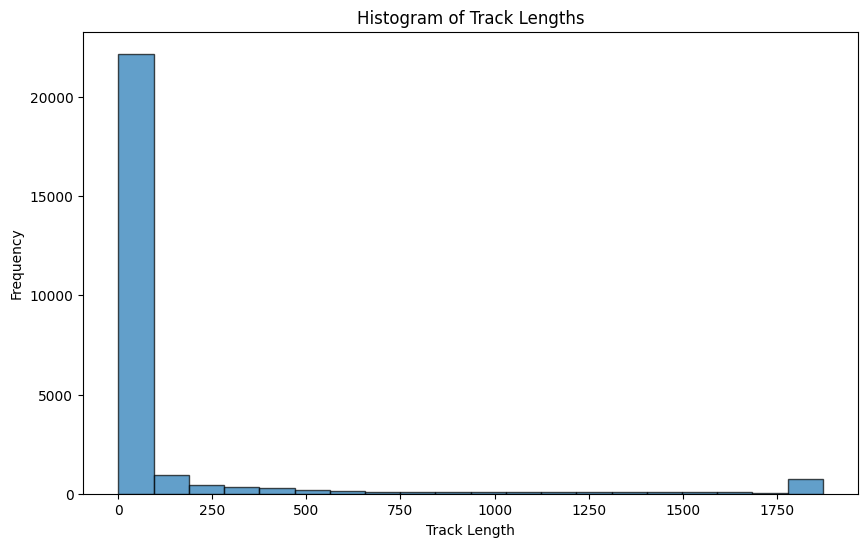

In [7]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

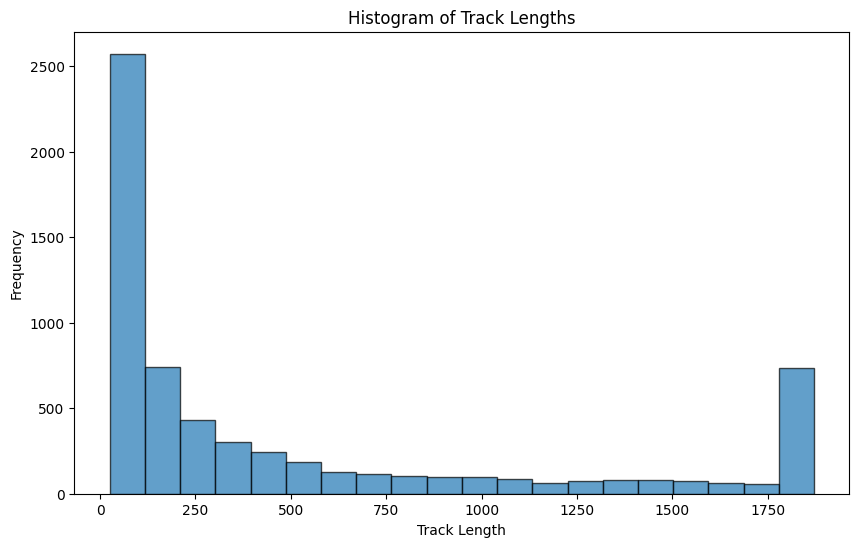

In [8]:
import matplotlib.pyplot as plt

track_sizes = merged_df.groupby("track_id")["track_id"].transform('size')
merged_df_long = merged_df[track_sizes >= TRK_MIN_LEN].copy()

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df_long["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

## Refined Config no optimization

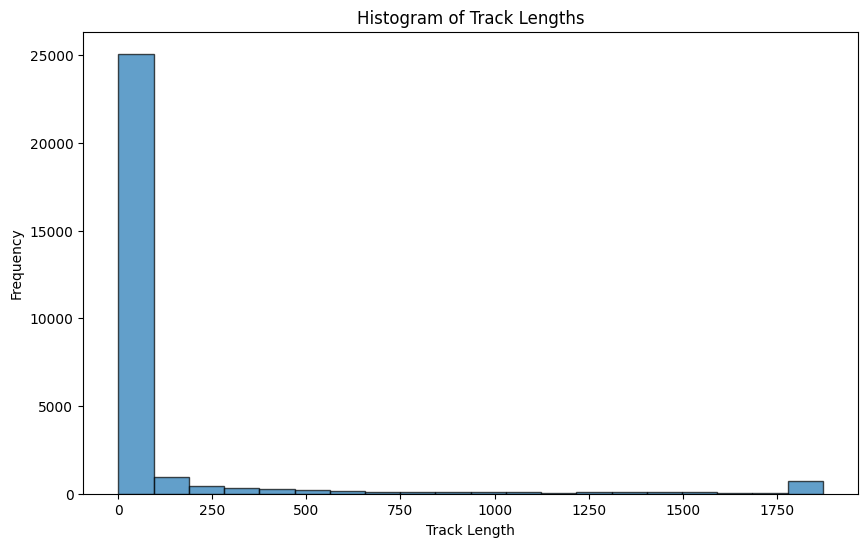

In [7]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

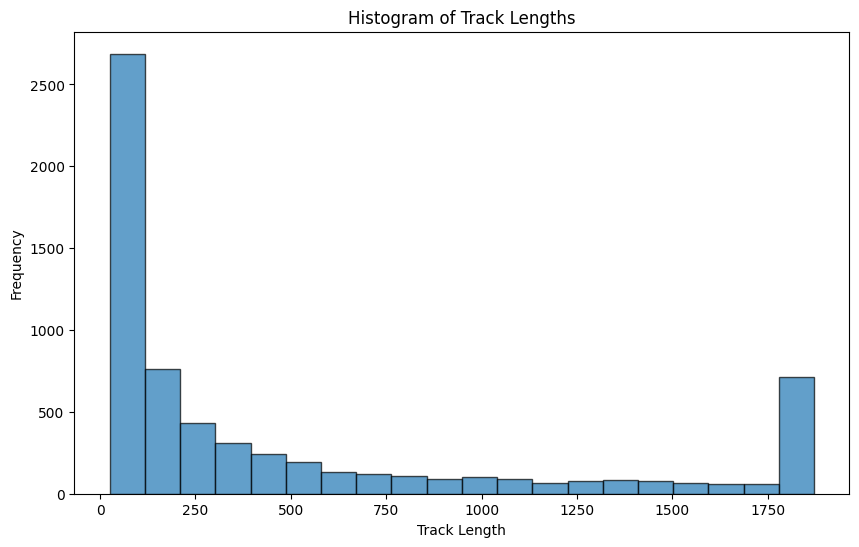

In [8]:
import matplotlib.pyplot as plt

track_sizes = merged_df.groupby("track_id")["track_id"].transform('size')
merged_df_long = merged_df[track_sizes >= TRK_MIN_LEN].copy()

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df_long["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

### First approach with default config

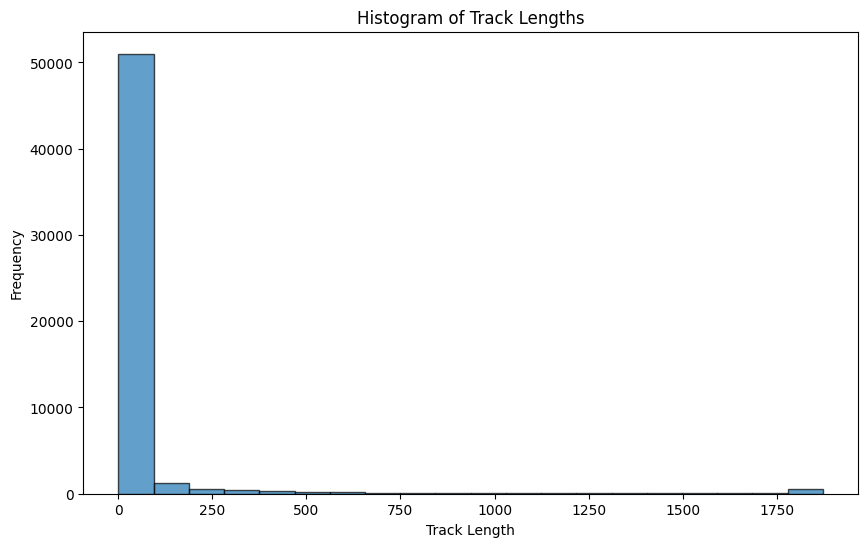

In [10]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

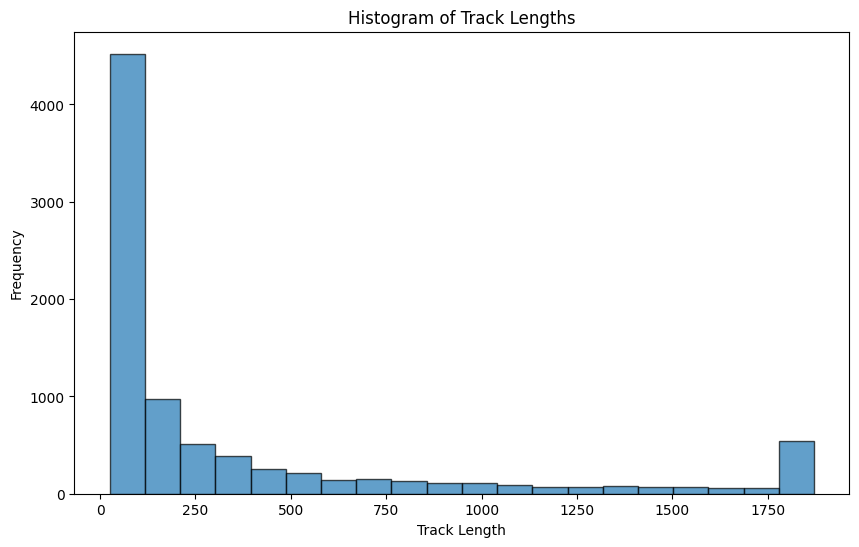

In [11]:
import matplotlib.pyplot as plt

track_sizes = merged_df.groupby("track_id")["track_id"].transform('size')
merged_df_long = merged_df[track_sizes >= TRK_MIN_LEN].copy()

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df_long["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()